## 1. Load Library & Data

In [1]:
# 최초 1회만 실행
import tarfile

data_root = 'dataset'
tar = tarfile.open("dataset/cifar-10-python.tar.gz")
tar.extractall(data_root)
tar.close()

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from collections import OrderedDict

In [3]:
from data_utils import load_CIFAR10

cifar10_dir = 'dataset/cifar-10-batches-py'

train_images, train_labels, test_images, test_labels = load_CIFAR10(cifar10_dir)

## 2. Data preprocessing

### 시각화

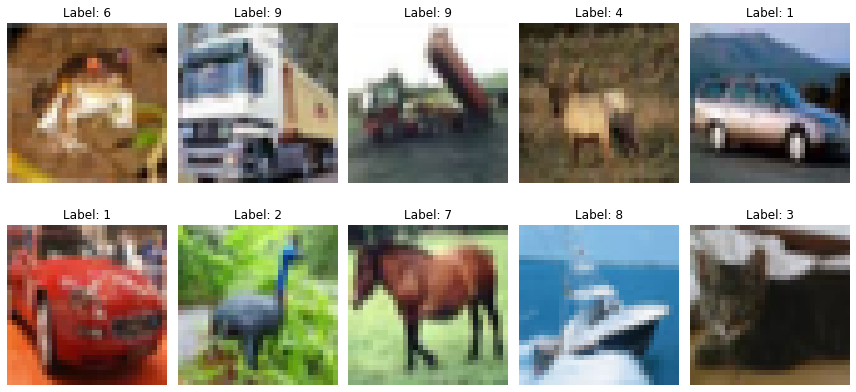

In [4]:
# 이미지 데이터 시각화
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

# 상위 10개의 이미지를 플롯으로 표시
for i in range(10):
    axes[i].imshow(train_images[i].astype('uint8'))
    axes[i].set_title("Label: {}".format(train_labels[i]))
    axes[i].axis('off')

plt.tight_layout()
plt.show()

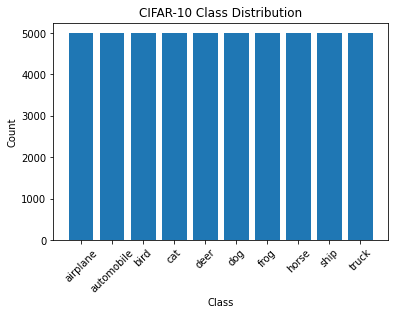

In [5]:
# 클래스 별 데이터 분포 히스토그램
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_counts = np.bincount(train_labels)

plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('CIFAR-10 Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [6]:
train_images = train_images.reshape(len(train_images.squeeze()), -1)
test_images = test_images.reshape(len(test_images.squeeze()), -1)

print('Training data shape: ', train_images.shape)
print('Training labels shape: ', train_labels.shape)
print('Test data shape: ', test_images.shape)
print('Test labels shape: ', test_labels.shape)

Training data shape:  (50000, 3072)
Training labels shape:  (50000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


## 3. Train

### model

In [7]:
class Linear:
    def __init__(self, input_size=1, hidden_size=1):
        self.W = np.random.randn(input_size, hidden_size)
        self.b = np.zeros(hidden_size)
        self.x = None
        self.dW = None
        self.db = None
        self.m =0
        self.v = 0
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout, lr):
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.x.T, dout)
        dx = np.dot(dout, self.W.T)
        
        self.m = self.beta1 * self.m + (1 - self.beta1) * self.dW
        self.v = self.beta2 * self.v + (1 - self.beta2) * (self.dW ** 2)
        m_hat = self.m / (1 - self.beta1)
        v_hat = self.v / (1 - self.beta2)
        
        self.W -= lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        self.b -= lr * self.db
        
        return dx

In [8]:
# Activation function
class Relu:
    def __init__(self) :
        self.mask =None
    
    def forward(self, x) :
        self.mask = (x < 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout) :
        dout[self.mask] = 0
        return dout    

class Leaky_Relu:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] *= self.alpha
        return out
    
    def backward(self, dout):
        dout[self.mask] *= self.alpha
        dx = dout
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1 / (1 + np.exp(-x)) # Sigmoid 함수 계산
        self.out = out # 역전파를 위해 출력 저장
        return out
    
    def backward(self, dout):
        dx = dout * self.out * (1 - self.out) # Sigmoid 함수의 역전파 계산식 적용
        return dx

class TanH:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = np.tanh(x) # TanH 함수 계산
        self.out = out # 역전파를 위해 출력 저장
        return out
    
    def backward(self, dout):
        dx = dout * (1 - self.out**2) # TanH 함수의 역전파 계산식 적용
        return dx

In [9]:
class Softmax_with_CrossEntropy :
    def __init__(self) :
        # softmax
        self.softmax_x = None 
        self.softmax_out = None
        # crossEntropy
        self.pred = None
        self.target = None
        self.delta = 1e-7
        
    def softmax_forward(self, x) :
        self.softmax_x = x
        tmp = np.max(self.softmax_x, axis=1).reshape(-1, 1)
        self.softmax_out = np.exp(self.softmax_x-tmp)/np.sum(np.exp(self.softmax_x-tmp), axis=1).reshape(-1,1)
        return self.softmax_out
    
    def crossEntropy_forward(self, pred, target) :
        self.pred = pred
        self.target = target
        loss = -np.sum(self.target*np.log(self.pred+self.delta), axis=1)
        return loss
    
    def backward(self) :
        dout = (self.pred-self.target)/len(self.pred)
        return dout

In [10]:
# one_hot label 만드는 함수
def make_one_hot(labels) :
    a = []
    for label in labels :
        one_hot = np.zeros(10)
        one_hot[label] = 1
        a.append(one_hot)
    a = np.array(a)
    return a

one_hot_labels = make_one_hot(train_labels)
print(train_labels[0])
print(one_hot_labels[0])

6
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [13]:
def eval(model, train_version = True) :
    if train_version :
        x = train_images
        labels = train_labels.squeeze()
        print('In train dataset ... ')
    else : 
        x = test_images
        labels = test_labels.squeeze()
        print('\nIn test dataset ... ')
    
    for layer in model.values() :
        if isinstance(layer, Softmax_with_CrossEntropy) :
            x = layer.softmax_forward(x)
        else :
            x = layer.forward(x)
            
    preds = x.argmax(axis=1)
    acc = np.sum(np.where(preds==labels, True, False))/len(labels)
    return acc

In [15]:
def train_MLP_v2(config):
    # 손실 이력을 저장하는 리스트
    loss_history = []
    
    lr, num_epoch, batch_size = config['learning_rate'], config['num_epoch'], config['batch_size']
    print_loss_interval = 25
    
    layer1 = Linear(3072, 1024)
    activation_function = Relu()
    layer2 = Linear(1024, 10)
    softmax_with_CE = Softmax_with_CrossEntropy()
    
    for iter in range(num_epoch):
        total_loss = 0
        for i in range(0, len(train_images), batch_size):
            # forward
            x = layer1.forward(train_images[i:i+batch_size])
            x = activation_function.forward(x)
            x = layer2.forward(x)
            preds = softmax_with_CE.softmax_forward(x)

            # loss
            one_hot_labels = make_one_hot(train_labels[i:i+batch_size])
            losses = softmax_with_CE.crossEntropy_forward(preds, one_hot_labels)
            loss = losses.sum() / len(preds)
            total_loss += loss

            # backward
            dL = softmax_with_CE.backward()
            dL = layer2.backward(dL, lr)
            dL = activation_function.backward(dL)
            dL = layer1.backward(dL, lr)

        # average loss
        loss = total_loss / (len(train_images) // batch_size)

        # 손실 이력에 손실 값을 추가
        loss_history.append(loss)
        

        if iter == 0 or (iter+1) % print_loss_interval == 0:
            print("[epoch %d / %d] average loss : %f" % (iter+1, num_epoch, loss)) 

        if loss < 0.05: break
            
    # 손실 그래프
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    model = OrderedDict()
    model['layer1'] = layer1
    model['activation_function'] = activation_function
    model['layer2'] = layer2
    model['softmax_with_CE'] = softmax_with_CE

    return model


---mini_batch---
[epoch 1 / 500] average loss : 12.073665
[epoch 25 / 500] average loss : 8.693730
[epoch 50 / 500] average loss : 7.159545
[epoch 75 / 500] average loss : 5.976229
[epoch 100 / 500] average loss : 5.302334
[epoch 125 / 500] average loss : 4.805042
[epoch 150 / 500] average loss : 4.656171
[epoch 175 / 500] average loss : 3.839223
[epoch 200 / 500] average loss : 3.478409
[epoch 225 / 500] average loss : 3.223718
[epoch 250 / 500] average loss : 2.918930
[epoch 275 / 500] average loss : 2.437860
[epoch 300 / 500] average loss : 2.319434
[epoch 325 / 500] average loss : 2.715278
[epoch 350 / 500] average loss : 2.325348
[epoch 375 / 500] average loss : 1.996714
[epoch 400 / 500] average loss : 1.510641
[epoch 425 / 500] average loss : 1.674542
[epoch 450 / 500] average loss : 1.608938
[epoch 475 / 500] average loss : 1.383828
[epoch 500 / 500] average loss : 1.280995


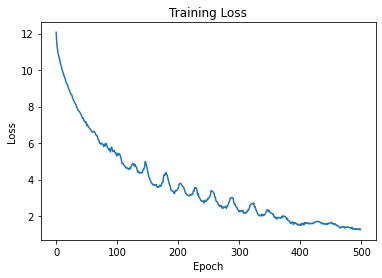

In [18]:
print('\n---mini_batch---')
config_mini_batch = { 'learning_rate' : 0.001,
            'num_epoch' : 500,
            'batch_size' : 64
          }
model_mini_batch = train_MLP_v2(config_mini_batch)

### Evaluation

In [19]:
print('\t Accuracy :', eval(model_mini_batch, train_version=True))
print('\t Accuracy :', eval(model_mini_batch, train_version=False))

In train dataset ... 
	 Accuracy : 0.84832

In test dataset ... 
	 Accuracy : 0.456
